# ## Tinkoff Финтех школа. осень 2018
### Предсказание отклика клиента. Домашняя работа.

Предсказание, что клиент согласится на предложение продукта банка.

In [1]:
import numpy as np
import pandas as pd
import os, sys
import time
from collections import OrderedDict
from tqdm import tqdm
import math
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from sklearn.metrics import roc_auc_score, log_loss

import lightgbm as lgb

**Загружаем данные**

In [2]:
dump_path = 'data'
df = pd.read_csv(os.path.join(dump_path,'train_m.csv'))

Колонки с признаками

In [3]:
continous_feats = ['add_base_flg', 's1_last_dates',  's1_prev_dates',  's1_request_flg', 'first_inc_call_dates', 
                   'first_out_call_dates', 's2_last_dates', 's2_prev_dates', 's2_request_flg', 'inc_call_cnt',
                   'last_inc_call_dates', 'last_out_call_dates', 's3_last_dates','s3_prev_dates', 's3_request_flg',
                   'out_call_cnt', 'prev_load_cnt', 'prev_load_dates', 'prev_s2s1', 'prev_s2s2', 'prev_s3s1', 
                   'prev_s3s2', 'prev_s1s1', 's2s1', 's2s2', 'skp_base_flg', 's3s1', 's3s2', 's1s1',
                   'user_contact_base_flg', 's3_available_flg', 's2_available_flg', 's1_available_flg']

categ_feats = ['utm_campaign', 'region', 'mob_provider', 'prev_load_status']

# Будем предсказывать вероятность, что клиент оставит заявку.
label = 'application_flg'

In [1]:
#df.head()

s1,s2,s3 - это 3 сервиса, данные которых мы запрашиваем. Данные по ним есть далеко не у всех.

### Разведочный анализ. 
#### Смотрим на распределение признаков. Ищем аномалии, выбросы.

In [2]:
#df.describe().style.format("{:.1f}")

Признаков много, заполнены далеко не все, есть категориальные.

### Обрабатываем категориальные переменные
LabelEncoding - каждое значение категориального признака кодируется целым числом.


Также можно применять OneHotEncoding, Target Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
le = dict([(f,LabelEncoder()) for f in categ_feats])
for f in categ_feats:
    df[f+'_le'] = le[f].fit_transform(df[f].astype(str))
    
feat_cols = continous_feats + [f + '_le' for f in categ_feats]

### Разбиваем выборку на обучающую и валидирующую

Валидационная выборка нужна для оценки качества модели. 

Более предпочитительный способ, но вычислительно более дорогой, использовать **кросс-валидацию**.

In [7]:
df_train = df.query('finish_dttm <  "2018-03-30"')
df_valid = df.query('finish_dttm >= "2018-03-30"')

#### В качестве метрики качества модели используем <a href=https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F> ROC AUC.</a>

## Дерево решений

Обработка пропущенных значений:
1. Флаг
2. Заменять средним, медианой, ближайшим.
3. Модель.

In [8]:
from sklearn.tree import DecisionTreeClassifier

dc = DecisionTreeClassifier(criterion='gini', max_depth=10)
dc.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

train_pred = dc.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
valid_pred = dc.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

roc_auc_train = roc_auc_score(df_train[label],train_pred)
roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)

print(f'Tree depth {dc.tree_.max_depth}.')
print(f'Decision tree on train sample. AUC ROC {roc_auc_train:.3f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
print(f'Decision tree on valid sample. AUC ROC {roc_auc_valid:.3f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

Tree depth 10.
Decision tree on train sample. AUC ROC 0.721. Logloss 0.36988.
Decision tree on valid sample. AUC ROC 0.639. Logloss 0.31164.


#### Рисуем кривую ROC.

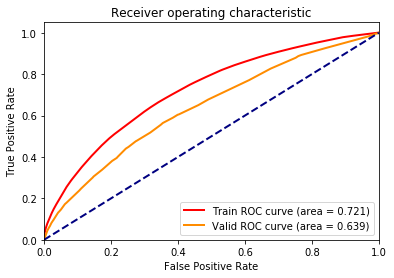

In [9]:
from sklearn.metrics import roc_curve, auc


plt.figure()
lw = 2
plt.plot(*roc_curve(df_train[label],train_pred)[:-1], color='red',
         lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
plt.plot(*roc_curve(df_valid[label],valid_pred)[:-1], color='darkorange',
         lw=lw, label='Valid ROC curve (area = %0.3f)' % roc_auc_valid)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Пример перебора гиперпараметров по сетке

In [10]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from collections import OrderedDict
import itertools


grid = OrderedDict((
        ('max_depth',np.arange(2,20,4)),
        ('min_samples_leaf',np.exp(np.linspace(3,8,5)).astype(int))
       ))

result = {'params':[],'roc_auc_train':[],'roc_auc_valid':[]}

for param_values in itertools.product(*grid.values()):
    param = dict(zip(grid.keys(),param_values))
    clf = DecisionTreeClassifier(**param)

    clf.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

    train_pred = clf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
    valid_pred = clf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

    roc_auc_train = roc_auc_score(df_train[label],train_pred)
    roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)
    result['params'].append(param)
    result['roc_auc_train'].append(roc_auc_train)
    result['roc_auc_valid'].append(roc_auc_valid)

# Выводим результаты    
(pd.DataFrame(result)   
   .style
   .background_gradient('Wistia')
)

CPU times: user 5min 35s, sys: 30.6 s, total: 6min 5s
Wall time: 5min 31s


In [11]:
# Выводим результаты    
(pd.DataFrame(result)   
   .style
   .background_gradient('Wistia')
)

,params,roc_auc_train,roc_auc_valid
0,"{'max_depth': 2, 'min_samples_leaf': 20}",0.647462,0.506257
1,"{'max_depth': 2, 'min_samples_leaf': 70}",0.647462,0.506257
2,"{'max_depth': 2, 'min_samples_leaf': 244}",0.647462,0.506257
3,"{'max_depth': 2, 'min_samples_leaf': 854}",0.647462,0.506257
4,"{'max_depth': 2, 'min_samples_leaf': 2980}",0.651389,0.562134
5,"{'max_depth': 6, 'min_samples_leaf': 20}",0.696044,0.61794
6,"{'max_depth': 6, 'min_samples_leaf': 70}",0.695909,0.618012
7,"{'max_depth': 6, 'min_samples_leaf': 244}",0.69544,0.617697
8,"{'max_depth': 6, 'min_samples_leaf': 854}",0.694767,0.617392
9,"{'max_depth': 6, 'min_samples_leaf': 2980}",0.688836,0.624824


#### Задание (2 балла): 
- Перебирать параметры: 
<br>**max_depth** - максимальная глубина дерева,
<br>**min_samples_leaf** - минимальное количество примеров обучающей выборки в листе, 
<br>**max_features** - количество признаков, рассматриваемых при сплите (разбиении на 2 подвыборки).
<br>Цель - Выбрать оптимальные значения параметров, максимизирующие **ROC AUC** на валидационной выборке. 
<br>Напишите в комментентариях, в каких пределах Вы искали параметры и почему.


- Взять лучшие параметры из GridSearch и построить график зависимости качества модели (**ROC AUC** на обучающей и валидационной выборках) от глубины дерева.

## Решение

##### Напишем функцию, принимающую метод и сетку

In [12]:
def grid_search(model, grid):
    result = {'params':[],'roc_auc_train':[],'roc_auc_valid':[]}
    for param_values in itertools.product(*grid.values()):
        param = dict(zip(grid.keys(),param_values))
        if model == 'DecisionTreeClassifier' or model == 'RandomForestClassifier':
            if model == 'DecisionTreeClassifier':
                clf = DecisionTreeClassifier(**param)
            if model == 'RandomForestClassifier':
                clf = RandomForestClassifier(**param)
            clf.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

            train_pred = clf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
            valid_pred = clf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

            roc_auc_train = roc_auc_score(df_train[label],train_pred)
            roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)
            result['params'].append(param)
            result['roc_auc_train'].append(roc_auc_train)
            result['roc_auc_valid'].append(roc_auc_valid)

        if model == 'gbm':
            pass #Допишем далее
    return result

In [13]:
parameters_DecisionTree = {
    'max_depth': np.arange(2,20,2),
    'min_samples_leaf': np.exp(np.linspace(2,8,6)).astype(int),
    'max_features': ['sqrt', 'log2', None], 
}

In [14]:
%%time
result = grid_search('DecisionTreeClassifier', parameters_DecisionTree)
# 20-30 мин

CPU times: user 32min 39s, sys: 3min 7s, total: 35min 46s
Wall time: 32min 2s


In [15]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [16]:
pandas_result.head()

,params,roc_auc_train,roc_auc_valid
0,"{'max_depth': 2, 'min_samples_leaf': 7, 'max_f...",0.620232,0.569917
1,"{'max_depth': 2, 'min_samples_leaf': 7, 'max_f...",0.616959,0.556948
2,"{'max_depth': 2, 'min_samples_leaf': 7, 'max_f...",0.647462,0.506257
3,"{'max_depth': 2, 'min_samples_leaf': 24, 'max_...",0.634775,0.564350
4,"{'max_depth': 2, 'min_samples_leaf': 24, 'max_...",0.617227,0.546164


In [17]:
pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]

params           {'max_depth': 16, 'min_samples_leaf': 897, 'ma...
roc_auc_train                                             0.714172
roc_auc_valid                                              0.64533
Name: 140, dtype: object

In [18]:
pandas_result.iloc[140]

params           {'max_depth': 16, 'min_samples_leaf': 897, 'ma...
roc_auc_train                                             0.714172
roc_auc_valid                                              0.64533
Name: 140, dtype: object

In [19]:
params_of_best = pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]['params']

In [20]:
params_of_best

{'max_depth': 16, 'max_features': None, 'min_samples_leaf': 897}

{'max_depth': 16, 'max_features': None, 'min_samples_leaf': 897}

In [21]:
#grid_cv_DecisionTree = GridSearchCV(DecisionTreeClassifier(), parameters_DecisionTree, scoring = 'roc_auc', cv = 2)
#grid_cv_DecisionTree.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])
# print(grid_cv_DecisionTree.best_score_)
# print('')
# print(grid_cv_DecisionTree.best_params_)
# print('')
# print(grid_cv_DecisionTree.best_estimator_)

### Комментарии по пределам значений
- Максимальная глубина выбрана сильно ограниченной в диапазоне, так как решающие деревья легко переобучаются
- Чем глубже, тем легче было бы переобучиться


- max_features просмотрен в стандартных значениях, можно было перебирать в диапазоне от sqrt до log, меньше, больше, но лучший результат получили на всех


- Минимальное количество примеров в листе следует выбирать, чтобы дерево не переобучилось, в данном случае получили около 900
- Мало - недостаточно и легко переобучиться
- Много - не найдем зависимость
- Диапазон выбран покрывающим несколько порядков значений

### Фиксируем лучшие, запускаем перебор глубины и строим графики

In [22]:
parameters_DecisionTree = {
    'max_depth': np.arange(2,30,2),
    'min_samples_leaf': [897],
    'max_features': [None], 
}

In [23]:
result = grid_search('DecisionTreeClassifier', parameters_DecisionTree)

In [24]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [25]:
pandas_result

,params,roc_auc_train,roc_auc_valid
0,"{'max_depth': 2, 'min_samples_leaf': 897, 'max...",0.646701,0.504368
1,"{'max_depth': 4, 'min_samples_leaf': 897, 'max...",0.675431,0.571766
2,"{'max_depth': 6, 'min_samples_leaf': 897, 'max...",0.694318,0.616886
3,"{'max_depth': 8, 'min_samples_leaf': 897, 'max...",0.704574,0.637571
4,"{'max_depth': 10, 'min_samples_leaf': 897, 'ma...",0.710773,0.642221
5,"{'max_depth': 12, 'min_samples_leaf': 897, 'ma...",0.712937,0.644038
6,"{'max_depth': 14, 'min_samples_leaf': 897, 'ma...",0.713889,0.644739
7,"{'max_depth': 16, 'min_samples_leaf': 897, 'ma...",0.714172,0.645330
8,"{'max_depth': 18, 'min_samples_leaf': 897, 'ma...",0.714251,0.645111
9,"{'max_depth': 20, 'min_samples_leaf': 897, 'ma...",0.714252,0.645112


In [26]:
depth = []
roc_auc_train = []
roc_auc_valid = []
for i in range(len(pandas_result)):
    depth.append(pandas_result['params'].iloc[i]['max_depth'])
    roc_auc_valid.append(pandas_result['roc_auc_valid'].iloc[i])
    roc_auc_train.append(pandas_result['roc_auc_train'].iloc[i])

###  train

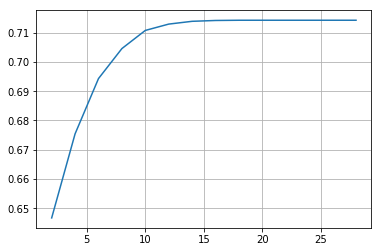

In [27]:
plt.plot(depth, roc_auc_train)
plt.grid(True)

### valid

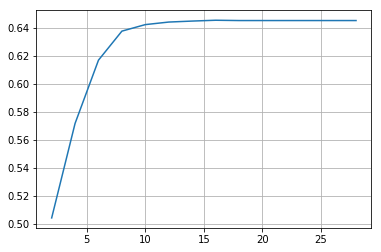

In [28]:
plt.plot(depth, roc_auc_valid)
plt.grid(True)

Качество на valid при росте глубины начинает уменьшаться

## Случайный лес

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=5)

rf.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

train_pred = rf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
valid_pred = rf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

print(f'Random forest on train sample. AUC ROC {roc_auc_score(df_train[label],train_pred):.3f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
print(f'Random forest on valid sample. AUC ROC {roc_auc_score(df_valid[label],valid_pred):.3f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

Random forest on train sample. AUC ROC 0.698. Logloss 0.38222.
Random forest on valid sample. AUC ROC 0.638. Logloss 0.25881.


#### Задание (2 балла): 
- Зафиксировать количество деревьев в 25 и перебирать параметры: 
<br> **max_depth** - максимальная глубина дерева,
<br>  **min_samples_leaf** - минимальное количество примеров обучающей выборки в листе, 
<br>  **max_features** - количество признаков, рассматриваемых при сплите (разбиении на 2 подвыборки).
<br>  Напишите в комментентариях, в каких пределах Вы искали параметры и почему. 
<br>  Цель - Выбрать оптимальные значения параметров, максимизирующие **ROC AUC** на валидационной выборке. 


- Построить график зависимости качества модели (**ROC AUC** на обучающей и валидационной выборках) от количества деревьев (n_estimators).

## Решение

In [30]:
parameters_RandomForest = {
    'n_estimators': [25],
    'max_depth': np.arange(2,15,4),
    'min_samples_leaf': np.exp(np.linspace(3,8,5)).astype(int),
    'max_features': ['sqrt', 'log2', None], 
}

In [31]:
%%time
result = grid_search('RandomForestClassifier', parameters_RandomForest)
# 20-30 мин

CPU times: user 35min 15s, sys: 1min 37s, total: 36min 52s
Wall time: 30min 28s


In [32]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [33]:
pandas_result.head()

,params,roc_auc_train,roc_auc_valid
0,"{'n_estimators': 25, 'max_depth': 2, 'min_samp...",0.671955,0.612735
1,"{'n_estimators': 25, 'max_depth': 2, 'min_samp...",0.670504,0.607495
2,"{'n_estimators': 25, 'max_depth': 2, 'min_samp...",0.669949,0.515747
3,"{'n_estimators': 25, 'max_depth': 2, 'min_samp...",0.682205,0.624325
4,"{'n_estimators': 25, 'max_depth': 2, 'min_samp...",0.669055,0.609529


In [34]:
pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]

params           {'n_estimators': 25, 'max_depth': 14, 'min_sam...
roc_auc_train                                             0.738539
roc_auc_valid                                              0.66712
Name: 53, dtype: object

In [35]:
params_of_best = pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]['params']

In [36]:
params_of_best

{'max_depth': 14,
 'max_features': None,
 'min_samples_leaf': 244,
 'n_estimators': 25}

In [37]:
# grid_cv_RandomForest = GridSearchCV(RandomForestClassifier(), parameters_DecisionTree, scoring = 'roc_auc', cv = 2)
# grid_cv_RandomForest.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])
# print(grid_cv_RandomForest.best_score_)
# print('')
# print(grid_cv_RandomForest.best_params_)
# print('')
# print(grid_cv_RandomForest.best_estimator_)

### Комментарии по пределам значений
- В данном случае уже не так страшно брать большую глубину, так как случайный лес является композицией деревьев и не подвержен большому переобучению именно из-за глубины каждого отдельного дерева (особенно при росте количества деревьев)


- Рассматриваем глубину в диапазоне, похожем на прошлое задание, с учетом графика зависимости ROC от глубины(в какой-то момент выходит на максимум и далее уменьшается)


- max_features просмотрен в стандартных значениях, можно было перебирать в диапазоне от sqrt до log, меньше, больше, но лучший результат получили на всех


- Минимальное количество примеров в листе выбираем тоже с учетом предыдущего задания, но в данном случае риск переобучиться тоже меньше, как и с глубиной дерева
- Диапазон выбран покрывающим несколько порядков значений

### Фиксируем лучшие, запускаем перебор количества деревьев и строим графики

In [38]:
parameters_RandomForest = {
    'n_estimators': np.arange(1,100,5),
    'max_depth': [14],
    'min_samples_leaf': [244],
    'max_features': [None], 
}

In [39]:
result = grid_search('RandomForestClassifier', parameters_RandomForest)

In [40]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [41]:
pandas_result

,params,roc_auc_train,roc_auc_valid
0,"{'n_estimators': 1, 'max_depth': 14, 'min_samp...",0.715844,0.628961
1,"{'n_estimators': 6, 'max_depth': 14, 'min_samp...",0.734907,0.658161
2,"{'n_estimators': 11, 'max_depth': 14, 'min_sam...",0.736810,0.663624
3,"{'n_estimators': 16, 'max_depth': 14, 'min_sam...",0.737721,0.663549
4,"{'n_estimators': 21, 'max_depth': 14, 'min_sam...",0.738373,0.664960
5,"{'n_estimators': 26, 'max_depth': 14, 'min_sam...",0.738849,0.666961
6,"{'n_estimators': 31, 'max_depth': 14, 'min_sam...",0.738564,0.665598
7,"{'n_estimators': 36, 'max_depth': 14, 'min_sam...",0.738993,0.666896
8,"{'n_estimators': 41, 'max_depth': 14, 'min_sam...",0.738757,0.666511
9,"{'n_estimators': 46, 'max_depth': 14, 'min_sam...",0.738962,0.666317


In [42]:
# 20-30 мин
n_estimators = []
roc_auc_train = []
roc_auc_valid = []
for i in range(len(pandas_result)):
    n_estimators.append(pandas_result['params'].iloc[i]['n_estimators'])
    roc_auc_valid.append(pandas_result['roc_auc_valid'].iloc[i])
    roc_auc_train.append(pandas_result['roc_auc_train'].iloc[i])

###  train

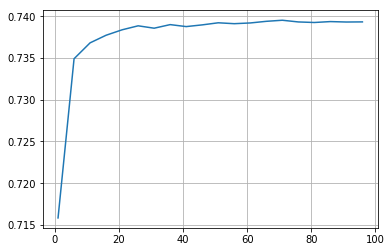

In [43]:
plt.plot(n_estimators, roc_auc_train)
plt.grid(True)

###  valid 

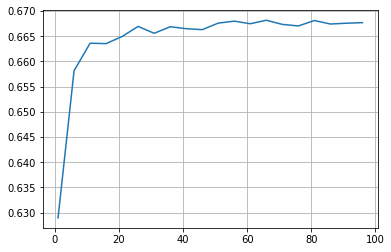

In [44]:
plt.plot(n_estimators, roc_auc_valid)
plt.grid(True)

### Замечание
- Строю до 100 деревьев, чтобы лучше увидеть зависимость
- На самом деле, при другом количестве деревьев следует делать grid search заново

## Градиентный бустинг

In [45]:
lgb_train = lgb.Dataset(df_train[feat_cols], df_train[label])
lgb_eval = lgb.Dataset(df_valid[feat_cols], df_valid[label], reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )

train_pred = gbm.predict(df_train[feat_cols], num_iteration=gbm.best_iteration)
valid_pred = gbm.predict(df_valid[feat_cols], num_iteration=gbm.best_iteration)

#print(f'Best iteration {gbm.best_iteration}.')
print(f'Grad boosting on train sample. AUC ROC {roc_auc_score(df_train[label],train_pred):.4f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
print(f'Grad boosting on valid sample. AUC ROC {roc_auc_score(df_valid[label],valid_pred):.4f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

Start training...
Grad boosting on train sample. AUC ROC 0.7218. Logloss 0.37335.
Grad boosting on valid sample. AUC ROC 0.6648. Logloss 0.25508.


#### Задание (2 балла): 
- Перебирать параметры: 
<br> **max_depth** - максимальная глубина дерева,
<br>  **min_samples_leaf** - минимальное количество примеров обучающей выборки в листе, 
<br>  **max_features** - количество признаков, рассматриваемых при сплите (разбиении на 2 подвыборки).
<br>  Напишите в комментентариях, в каких пределах Вы искали параметры и почему. 
<br>  Цель - Выбрать оптимальные значения параметров, максимизирующие **ROC AUC** на валидационной выборке. 

**NB** <a href=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/> Статья </a> как тюнить параметры градиентного бустинга.
    
    
- Построить график зависимости качества модели (**ROC AUC** на обучающей и валидационной выборках) от количества деревьев (n_estimators).
<br> Для этого построить модель один раз на максмальном количестве деревьев, закомментировав поле **early_stopping_rounds** в методе `train`. Далее использовать параметр **num_iteration** в функции `gbm.predict`.



## Решение

In [46]:
def grid_search(model, grid):
    
    lgb_train = lgb.Dataset(df_train[feat_cols], df_train[label])
    lgb_eval = lgb.Dataset(df_valid[feat_cols], df_valid[label], reference=lgb_train)
    
    result = {'params':[],'roc_auc_train':[],'roc_auc_valid':[]}
    for param_values in itertools.product(*grid.values()):
        param = dict(zip(grid.keys(),param_values))
        if model == 'DecisionTreeClassifier' or model == 'RandomForestClassifier':
            if model == 'DecisionTreeClassifier':
                clf = DecisionTreeClassifier(**param)
            if model == 'RandomForestClassifier':
                clf = RandomForestClassifier(**param)
            clf.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

            train_pred = clf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
            valid_pred = clf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

            roc_auc_train = roc_auc_score(df_train[label],train_pred)
            roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)
            result['params'].append(param)
            result['roc_auc_train'].append(roc_auc_train)
            result['roc_auc_valid'].append(roc_auc_valid)

        if model == 'gbm':
            gbm = lgb.train(param,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )
            train_pred = gbm.predict(df_train[feat_cols], num_iteration=gbm.best_iteration)
            valid_pred = gbm.predict(df_valid[feat_cols], num_iteration=gbm.best_iteration)
            roc_auc_train = roc_auc_score(df_train[label],train_pred)
            roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)
            result['params'].append(param)
            result['roc_auc_train'].append(roc_auc_train)
            result['roc_auc_valid'].append(roc_auc_valid)
    return result

In [47]:
params = {
    'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'metric': [{'l2', 'auc'}],
    'num_leaves': [31],
    'learning_rate': [0.05],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [1],
    'max_depth': np.arange(2,15,4),
    'min_data_in_leaf': np.exp(np.linspace(3,8,5)).astype(int),
    'feature_fraction': [0.1, 0.3, 0.6, 0.9],
    'n_estimators': [100]
}

In [48]:
%%time
result = grid_search('gbm', params)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 33min 40s, sys: 1min 2s, total: 34min 43s
Wall time: 10min 13s


In [49]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [50]:
pandas_result.head()

,params,roc_auc_train,roc_auc_valid
0,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.698480,0.649978
1,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.704490,0.651845
2,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.690037,0.628950
3,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.707359,0.655436
4,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.698480,0.649978


In [51]:
pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]

params           {'task': 'train', 'boosting_type': 'gbdt', 'ob...
roc_auc_train                                             0.730914
roc_auc_valid                                             0.681284
Name: 74, dtype: object

In [52]:
params_of_best = pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]['params']

In [53]:
params_of_best

{'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6,
 'learning_rate': 0.05,
 'max_depth': 14,
 'metric': {'auc', 'l2'},
 'min_data_in_leaf': 854,
 'num_leaves': 31,
 'objective': 'binary',
 'task': 'train',
 'verbose': 1}

In [54]:
# grid_cv_gbm = GridSearchCV(lgb.LGBMClassifier(), parameters_gbm, scoring = 'roc_auc', cv = 2)
# grid_cv_gbm.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])
# print(grid_cv_gbm.best_score_)
# print('')
# print(grid_cv_gbm.best_params_)
# print('')
# print(grid_cv_gbm.best_estimator_)

### Комментарии по пределам значений
- максимальная глубина, как и ранее, выбирается не слишком большой, чтобы не переобучиться
- min_samples_leaf в таких же диапазонах, исходя из результатов
- max_features выбран из трех промежуточных значений, которые позволяют понять общую картину и в какую сторону сдвигать

### Фиксируем лучшие, запускаем перебор количества деревьев и строим графики

In [55]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 14,
    'min_data_in_leaf': 854,
    'n_estimators': 100
}

In [56]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                #early_stopping_rounds=10,
                verbose_eval = False
           )

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [57]:
# 15 мин
n_estimators = []
roc_auc_train = []
roc_auc_valid = []
for i in range(1,100):
    n_estimators.append(i)
    valid_pred = gbm.predict(df_valid[feat_cols], num_iteration=i)
    train_pred = gbm.predict(df_train[feat_cols], num_iteration=i)
    roc_auc_valid.append(roc_auc_score(df_valid[label],valid_pred))
    roc_auc_train.append(roc_auc_score(df_train[label],train_pred))

### train

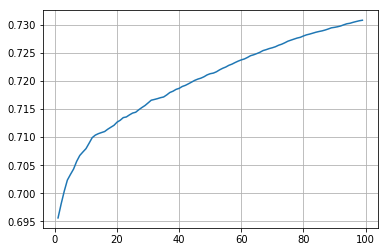

In [58]:
plt.plot(n_estimators, roc_auc_train)
plt.grid(True)

### valid 

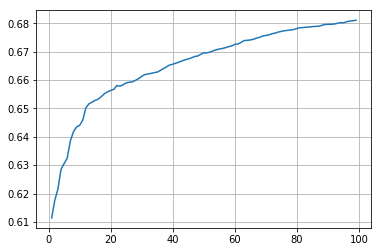

In [59]:
plt.plot(n_estimators, roc_auc_valid)
plt.grid(True)

### При увеличении количества деревьев видим переобучение
- Особенно это заметно при обучении на 300 деревьях, например (на valid выходит на асимптоту)
- Не привожу, так как долго считает

### Заполняя пропуски (Происходящее не изменилось значительно, для интереса вывожу на valid)

In [60]:
new_df_train = df_train[feat_cols].fillna(df_train[feat_cols].mean())
new_df_valid = df_valid[feat_cols].fillna(df_train[feat_cols].mean())
new_df_train[label] = df_train[label]
new_df_valid[label] = df_valid[label]

In [61]:
params = {
    'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'metric': [{'l2', 'auc'}],
    'num_leaves': [31],
    'learning_rate': [0.05],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [1],
    'max_depth': np.arange(2,15,4),
    'min_data_in_leaf': np.exp(np.linspace(3,8,5)).astype(int),
    'feature_fraction': [0.1, 0.3, 0.6, 0.9],
    'n_estimators': [100]
}

In [62]:
def grid_search(model, grid):
    
    lgb_train = lgb.Dataset(new_df_train[feat_cols], new_df_train[label])
    lgb_eval = lgb.Dataset(new_df_valid[feat_cols], new_df_valid[label], reference=lgb_train)
    
    result = {'params':[],'roc_auc_train':[],'roc_auc_valid':[]}
    for param_values in itertools.product(*grid.values()):
        param = dict(zip(grid.keys(),param_values))
        if model == 'DecisionTreeClassifier' or model == 'RandomForestClassifier':
            if model == 'DecisionTreeClassifier':
                clf = DecisionTreeClassifier(**param)
            if model == 'RandomForestClassifier':
                clf = RandomForestClassifier(**param)
            clf.fit(df_train[feat_cols].fillna(df_train[feat_cols].mean()),df_train[label])

            train_pred = clf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
            valid_pred = clf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

            roc_auc_train = roc_auc_score(df_train[label],train_pred)
            roc_auc_valid = roc_auc_score(df_valid[label],valid_pred)
            result['params'].append(param)
            result['roc_auc_train'].append(roc_auc_train)
            result['roc_auc_valid'].append(roc_auc_valid)

        if model == 'gbm':
            gbm = lgb.train(param,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )
            train_pred = gbm.predict(new_df_train[feat_cols], num_iteration=gbm.best_iteration)
            valid_pred = gbm.predict(new_df_valid[feat_cols], num_iteration=gbm.best_iteration)
            roc_auc_train = roc_auc_score(new_df_train[label],train_pred)
            roc_auc_valid = roc_auc_score(new_df_valid[label],valid_pred)
            result['params'].append(param)
            result['roc_auc_train'].append(roc_auc_train)
            result['roc_auc_valid'].append(roc_auc_valid)
    return result

In [63]:
%%time
result = grid_search('gbm', params)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 32min 24s, sys: 57.6 s, total: 33min 22s
Wall time: 9min 43s


In [64]:
# Выводим результаты    
pandas_result = (pd.DataFrame(result))

In [65]:
pandas_result.head()

,params,roc_auc_train,roc_auc_valid
0,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.699075,0.653144
1,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.704087,0.653138
2,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.705617,0.654766
3,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.706437,0.657277
4,"{'task': 'train', 'boosting_type': 'gbdt', 'ob...",0.699075,0.653144


In [66]:
pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]

params           {'task': 'train', 'boosting_type': 'gbdt', 'ob...
roc_auc_train                                             0.732238
roc_auc_valid                                             0.681279
Name: 43, dtype: object

In [67]:
params_of_best = pandas_result.loc[pandas_result['roc_auc_valid'].idxmax()]['params']

In [68]:
params_of_best

{'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.05,
 'max_depth': 10,
 'metric': {'auc', 'l2'},
 'min_data_in_leaf': 20,
 'num_leaves': 31,
 'objective': 'binary',
 'task': 'train',
 'verbose': 1}

#### Лучшие без пропусков (для сравнения смотрю на valid)

In [69]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 14,
    'min_data_in_leaf': 854,
    'n_estimators': 100
}

In [70]:
new_lgb_train = lgb.Dataset(new_df_train[feat_cols], new_df_train[label])
new_lgb_eval = lgb.Dataset(new_df_valid[feat_cols], new_df_valid[label], reference=new_lgb_train)
gbm = lgb.train(params,
                new_lgb_train,
                num_boost_round=50,
                valid_sets=new_lgb_eval,
                #early_stopping_rounds=10,
                verbose_eval = False
           )

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [71]:
# 15 мин
n_estimators = []
roc_auc_train = []
roc_auc_valid = []
for i in range(1,100):
    n_estimators.append(i)
    valid_pred = gbm.predict(new_df_valid[feat_cols], num_iteration=i)
    train_pred = gbm.predict(new_df_train[feat_cols], num_iteration=i)
    roc_auc_valid.append(roc_auc_score(new_df_valid[label],valid_pred))
    roc_auc_train.append(roc_auc_score(new_df_train[label],train_pred))

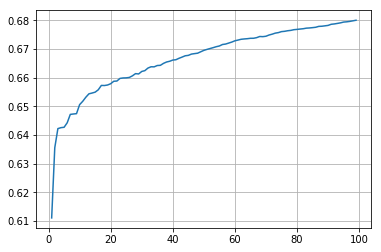

In [72]:
#valid
plt.plot(n_estimators, roc_auc_valid)
plt.grid(True)



## Важность признаков


Отсортировать признаки по важности разными способами:

 - Случайный лес. Испольовать атрибут `feature_importance_`. (**0.5 балла**)
 - Information value (**1 балл**).
 - Градиентный бустинг. Испольовать атрибут `feature_importance` . (**0.5 балла**)
 - ROC AUC унивариантной модели. Модель предсказывает целевую переменную только с помощью одного признака. (**2 балла**)
 - Перемешать значения только этого признака на  валидационной выборке и посмотреть, насколько ухудшится качество модели. В качестве модели взять градиентный бустинг. (**2 балла**)

Вывести эти списки со значениями важности.

Для каждого полученного списка признаков построить кривую на графике. По оси абсцисс идет количество признаков из верха списка. По оси ординат качество на валидационной выборке модели, построенной по этим признакам.
Полученные кривые вывести на одном графике. (**1 балл**)
<br><br>
**Бонусное задание без баллов**.  
Отсортировать признаки Логрегрессией с L1 - регуляризацией. 
<br> Использовать `sklearn.linear_model.LogisticRegression(penalty='l1',C)`, варьируя `С`. 
<br> Предварительно необходимо обеспечить независимость признаков, линейность по **WOE**, и все прочие шаги предобработки признаков из предыдующих лекций.
<br><br>

**NB**. Больше про отбор признаков http://scikit-learn.org/stable/modules/feature_selection.html

## Решение

In [73]:
new_df_train = df_train[feat_cols].fillna(df_train[feat_cols].mean())
new_df_valid = df_valid[feat_cols].fillna(df_train[feat_cols].mean())

#### Случайный лес

In [74]:
rf = RandomForestClassifier(n_estimators=25, max_depth=14, max_features=None, min_samples_leaf=244)

rf.fit(new_df_train,df_train[label])

train_pred = rf.predict_proba(df_train[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]
valid_pred = rf.predict_proba(df_valid[feat_cols].fillna(df_train[feat_cols].mean()))[:,1]

print(f'Random forest on train sample. AUC ROC {roc_auc_score(df_train[label],train_pred):.3f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
print(f'Random forest on valid sample. AUC ROC {roc_auc_score(df_valid[label],valid_pred):.3f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

Random forest on train sample. AUC ROC 0.738. Logloss 0.36645.
Random forest on valid sample. AUC ROC 0.666. Logloss 0.25324.


In [75]:
rf.feature_importances_

array([1.60406947e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.53569937e-04, 5.27100837e-03, 7.31458357e-03, 4.29677723e-03,
       2.14207447e-05, 2.12857009e-03, 7.28169556e-04, 4.36242677e-03,
       7.93860048e-03, 1.83573556e-02, 9.33660723e-07, 5.08417465e-03,
       4.45725911e-04, 1.72842050e-02, 1.25878337e-03, 4.24611587e-03,
       4.38748552e-02, 7.87077179e-02, 0.00000000e+00, 3.31186607e-02,
       2.85694688e-02, 9.76136917e-04, 5.74146564e-02, 2.04659716e-01,
       7.47750360e-05, 7.42845818e-05, 0.00000000e+00, 2.78474186e-05,
       3.79565956e-05, 1.45378508e-01, 1.72702308e-02, 1.49665502e-02,
       2.79715520e-01])

In [76]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [77]:
indices

array([36, 27, 33, 21, 26, 20, 23, 24, 13, 17, 34,  0, 35, 12,  6,  5, 15,
       11,  7, 19,  9, 18, 25, 10, 16,  4, 28, 29, 32, 31,  8, 14, 30, 22,
        3,  2,  1])

In [78]:
randomforest_features = []
for f in indices:
    randomforest_features.append(df_train[feat_cols].columns[f])
    print((df_train[feat_cols].columns[f], indices[f], importances[f]))

('prev_load_status_le', 1, 0.2797155201070504)
('s3s2', 29, 0.20465971614661535)
('utm_campaign_le', 22, 0.1453785075893112)
('prev_s3s2', 18, 0.07870771788702313)
('s3s1', 28, 0.057414656406229184)
('prev_s3s1', 9, 0.043874855247814405)
('s2s1', 10, 0.03311866073973293)
('s2s2', 16, 0.028569468750502893)
('s3_prev_dates', 12, 0.018357355557389682)
('prev_load_dates', 11, 0.017284205021760903)
('region_le', 3, 0.017270230848249916)
('add_base_flg', 36, 0.016040694705155206)
('mob_provider_le', 2, 0.014966550232898555)
('s3_last_dates', 35, 0.007938600477231664)
('s2_last_dates', 23, 0.007314583572405876)
('first_out_call_dates', 20, 0.0052710083747462165)
('out_call_cnt', 5, 0.005084174651559865)
('last_out_call_dates', 0, 0.004362426767190695)
('s2_prev_dates', 24, 0.004296777229321941)
('prev_s2s2', 19, 0.004246115867859956)
('inc_call_cnt', 17, 0.0021285700908876435)
('prev_s2s1', 7, 0.0012587833701050563)
('skp_base_flg', 4, 0.0009761369168775759)
('last_inc_call_dates', 34, 0.0007

#### IV

In [79]:
def bad_rate(df,feature,target,num_buck = 10):
    '''
    df - датафрейм
    feature - признак (название столбца в датафрейме)
    target - название целевой переменной
    num_buck - количество бакетов
    Функция считает bad_rate для каждого бакета
    Возвращает датафрейм с аггрегациями (сумма просрочек в бакете, среднее значение предсказания,
    количество заявок в бакете, среднее значение признака в бакете)
    '''
    return df.assign(bucket = np.ceil(df[feature].rank(pct = True) * num_buck),obj_count = 1)\
             .groupby('bucket')\
             .agg({target:'sum','obj_count':sum,feature:'mean'})\
             .rename(columns = {target:'target_sum',feature:'average'})\
             .assign(bad_rate = lambda x:x.target_sum/x.obj_count)
                
from math import log
def woe(df,feature,target,num_buck = 10):
    '''считаем woe
       df - датафрейм
       feature - признак
       predict - предсказание
       target - целевая переменная
       num_buck - количество бакетов
       Считаем woe, так как признаки могут принимать значения 0, добавляем малую константу 0.00001
    '''
    agg = bad_rate(df,feature,target,num_buck).reset_index()
    agg = agg[agg.target_sum != 0]
    return agg.assign(woe = lambda x:(x.bad_rate/(1-x.bad_rate)).apply(log) -
                      log((df[target].sum()/(len(df) - df[target].sum())))).set_index('bucket')

def IV(df,feature, target, num_buck = 10):
    '''df - датафрейм
       feature - название признака для которого считать IV
       num_buck - число бакетов
    '''
    iv = 0
    woe_table = woe(df,feature,target, num_buck).reset_index(drop=True)
    #display(woe_table)
    for i in range(len(woe_table)):
        iv += -woe_table.woe[i] * ((woe_table.obj_count[i] - woe_table.target_sum[i])/ \
                                   len(df[df[label] == 0])-(woe_table.target_sum)[i]/ \
                                   len(df[df[label] == 1]))
    return iv

In [80]:
new_df_train[label] = df_train[label]
new_df_valid[label] = df_valid[label]

In [81]:
IV(new_df_train, 'add_base_flg', label, num_buck=3)

0.21556318730259297

In [82]:
sorted_features = [(feature, IV(df_train, feature, label, num_buck=10)) for feature in list(feat_cols) \
                   if feature != label]

In [83]:
import operator
sorted_features.sort(key=operator.itemgetter(1), reverse=True)

In [84]:
#sorted_features = list(map(lambda x: x[0], sorted_features))

In [85]:
sorted_features

[('prev_load_status_le', 0.30063130296666013),
 ('utm_campaign_le', 0.22753106036628756),
 ('add_base_flg', 0.21556318730259297),
 ('s3s2', 0.1952876790928496),
 ('out_call_cnt', 0.18631580469073447),
 ('prev_load_cnt', 0.18328172397048528),
 ('prev_s3s2', 0.1302988230280809),
 ('s3_prev_dates', 0.12672670484102674),
 ('prev_load_dates', 0.11362955311671384),
 ('last_out_call_dates', 0.11154885419745555),
 ('first_out_call_dates', 0.10951535505409649),
 ('prev_s3s1', 0.09710297673210816),
 ('s2_prev_dates', 0.0760005868516418),
 ('s3s1', 0.07138996441433587),
 ('prev_s2s1', 0.07074206842510589),
 ('s2s1', 0.06718591850960653),
 ('s2_last_dates', 0.06194652976972947),
 ('prev_s2s2', 0.05918026822811316),
 ('region_le', 0.031929955908166094),
 ('s3_last_dates', 0.023909452250741113),
 ('s2_request_flg', 0.02193682850336619),
 ('s2_available_flg', 0.02193682850336619),
 ('s3_request_flg', 0.018517116687449046),
 ('s3_available_flg', 0.018517116687449046),
 ('s1_last_dates', 0.017318463760

In [86]:
IV_features = [sorted_feature[0] for sorted_feature in sorted_features]

#### Градиентный бустинг

In [87]:
lgb_train = lgb.Dataset(df_train[feat_cols], df_train[label])
lgb_eval = lgb.Dataset(df_valid[feat_cols], df_valid[label], reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 14,
    'min_data_in_leaf': 854,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [88]:
gbm.feature_importance()

array([ 52,  29,   0,   0,  30,  71,  27,  32,   0,   9,  55, 107,  29,
        93,   0,  97,  33, 127,  21,   6, 254, 176,   0, 345, 210,   7,
       285, 257,  40,  20,   0,   0,   2, 138, 244,  80, 124])

In [89]:
importances = gbm.feature_importance()
indices = np.argsort(importances)[::-1]

In [90]:
for f in indices:
    print((df_train[feat_cols].columns[f], f, importances[f]))

('s2s1', 23, 345)
('s3s1', 26, 285)
('s3s2', 27, 257)
('prev_s3s1', 20, 254)
('region_le', 34, 244)
('s2s2', 24, 210)
('prev_s3s2', 21, 176)
('utm_campaign_le', 33, 138)
('prev_load_dates', 17, 127)
('prev_load_status_le', 36, 124)
('last_out_call_dates', 11, 107)
('out_call_cnt', 15, 97)
('s3_prev_dates', 13, 93)
('mob_provider_le', 35, 80)
('first_out_call_dates', 5, 71)
('last_inc_call_dates', 10, 55)
('add_base_flg', 0, 52)
('s1s1', 28, 40)
('prev_load_cnt', 16, 33)
('s2_prev_dates', 7, 32)
('first_inc_call_dates', 4, 30)
('s1_last_dates', 1, 29)
('s3_last_dates', 12, 29)
('s2_last_dates', 6, 27)
('prev_s2s1', 18, 21)
('user_contact_base_flg', 29, 20)
('inc_call_cnt', 9, 9)
('skp_base_flg', 25, 7)
('prev_s2s2', 19, 6)
('s1_available_flg', 32, 2)
('prev_s1s1', 22, 0)
('s2_request_flg', 8, 0)
('s2_available_flg', 31, 0)
('s3_available_flg', 30, 0)
('s3_request_flg', 14, 0)
('s1_request_flg', 3, 0)
('s1_prev_dates', 2, 0)


#### Заполняя пропуски

In [91]:
lgb_train = lgb.Dataset(new_df_train[feat_cols], new_df_train[label])
lgb_eval = lgb.Dataset(new_df_valid[feat_cols], new_df_valid[label], reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 14,
    'min_data_in_leaf': 854,
    'n_estimators': 100
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [92]:
gbm.feature_importance()

array([ 55,  17,   0,   5,  13,  43,  28,  24,   3,  50,  15,  74,  39,
       108,   0, 116,  40, 111,  15,   9, 239, 172,   0, 308, 258,  11,
       305, 272,  35,  21,   0,   0,   3, 136, 243,  81, 151])

In [93]:
importances = gbm.feature_importance()
indices = np.argsort(importances)[::-1]

In [94]:
gbm_features = []
for f in indices:
    gbm_features.append(new_df_train[feat_cols].columns[f])
    print((new_df_train[feat_cols].columns[f], indices[f], importances[f]))

('s2s1', 1, 308)
('s3s1', 4, 305)
('s3s2', 25, 272)
('s2s2', 10, 258)
('region_le', 30, 243)
('prev_s3s1', 6, 239)
('prev_s3s2', 7, 172)
('prev_load_status_le', 22, 151)
('utm_campaign_le', 14, 136)
('out_call_cnt', 9, 116)
('prev_load_dates', 16, 111)
('s3_prev_dates', 11, 108)
('mob_provider_le', 2, 81)
('last_out_call_dates', 13, 74)
('add_base_flg', 23, 55)
('inc_call_cnt', 15, 50)
('first_out_call_dates', 20, 43)
('prev_load_cnt', 5, 40)
('s3_last_dates', 35, 39)
('s1s1', 19, 35)
('s2_last_dates', 21, 28)
('s2_prev_dates', 36, 24)
('user_contact_base_flg', 3, 21)
('s1_last_dates', 26, 17)
('last_inc_call_dates', 17, 15)
('prev_s2s1', 12, 15)
('first_inc_call_dates', 34, 13)
('skp_base_flg', 18, 11)
('prev_s2s2', 28, 9)
('s1_request_flg', 24, 5)
('s1_available_flg', 31, 3)
('s2_request_flg', 33, 3)
('s2_available_flg', 8, 0)
('s3_request_flg', 0, 0)
('s3_available_flg', 32, 0)
('s1_prev_dates', 27, 0)
('prev_s1s1', 29, 0)


#### ROC AUC унивариантной модели
- Далее используем после заполнения пропусков (на семинаре gbm строился без заполнения пропусков)

In [95]:
#3 мин
train_pred = []
valid_pred = []
for feat_col in feat_cols:
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[[feat_col]]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[[feat_col]]), new_df_valid[label], reference=lgb_train)

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
}

#print('Start training...')
# train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False
               )
    
    train_value = gbm.predict(new_df_train[[feat_col]], num_iteration=gbm.best_iteration)
    valid_value = gbm.predict(new_df_valid[[feat_col]], num_iteration=gbm.best_iteration)
    
    train_pred.append(roc_auc_score(new_df_train[label],train_value))
    valid_pred.append(roc_auc_score(new_df_valid[label],valid_value))

#print(f'Best iteration {gbm.best_iteration}.')
#print(f'Grad boosting on train sample. AUC ROC {roc_auc_score(df_train[label],train_pred):.4f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
#print(f'Grad boosting on valid sample. AUC ROC {roc_auc_score(df_valid[label],valid_pred):.4f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [96]:
rocs = [(feat_cols[i], train_pred[i]) for i in range(len(feat_cols))]

In [97]:
rocs.sort(key=operator.itemgetter(1), reverse=True)

In [98]:
rocs

[('prev_load_status_le', 0.6367297796141949),
 ('s3s2', 0.631781891489631),
 ('prev_load_dates', 0.629376765449518),
 ('utm_campaign_le', 0.6235777735256495),
 ('last_out_call_dates', 0.62301276650224),
 ('first_out_call_dates', 0.6225562215002616),
 ('out_call_cnt', 0.615195164590259),
 ('prev_load_cnt', 0.6120127402267589),
 ('s3s1', 0.6103908638548851),
 ('add_base_flg', 0.607402509735583),
 ('prev_s3s1', 0.6070030070518947),
 ('s3_prev_dates', 0.6066875472509338),
 ('prev_s3s2', 0.6064321360506771),
 ('s2_last_dates', 0.5840660489640096),
 ('s2s1', 0.5781576626169062),
 ('s2_prev_dates', 0.5777763567664589),
 ('s2s2', 0.5776414422735794),
 ('prev_s2s2', 0.5747521758212442),
 ('prev_s2s1', 0.574668679571517),
 ('region_le', 0.5690005886650767),
 ('s3_last_dates', 0.5645676681472667),
 ('mob_provider_le', 0.5334467170094822),
 ('s2_request_flg', 0.5175407241909),
 ('s2_available_flg', 0.5175407241909),
 ('s3_request_flg', 0.5147265179751308),
 ('s3_available_flg', 0.5147265179751308)

In [99]:
rocs_feautures = [roc[0] for roc in rocs]

#### Перемешивание

In [100]:
#3 мин
lgb_train = lgb.Dataset(new_df_train[feat_cols], new_df_train[label])
lgb_eval = lgb.Dataset(new_df_valid[feat_cols], new_df_valid[label], reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 14,
    'min_data_in_leaf': 200,
    'n_estimators': 100
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval = False
           )

train_pred = gbm.predict(new_df_train[feat_cols], num_iteration=gbm.best_iteration)
valid_pred = gbm.predict(new_df_valid[feat_cols], num_iteration=gbm.best_iteration)

#print(f'Best iteration {gbm.best_iteration}.')
print(f'Grad boosting on train sample. AUC ROC {roc_auc_score(new_df_train[label],train_pred):.4f}. Logloss {log_loss(df_train[label],train_pred):.5f}.')
print(f'Grad boosting on valid sample. AUC ROC {roc_auc_score(new_df_valid[label],valid_pred):.4f}. Logloss {log_loss(df_valid[label],valid_pred):.5f}.')

Start training...


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Grad boosting on train sample. AUC ROC 0.7313. Logloss 0.36868.
Grad boosting on valid sample. AUC ROC 0.6808. Logloss 0.25110.


In [101]:
prediction_before_mixing = roc_auc_score(new_df_valid[label],valid_pred)

In [102]:
prediction_before_mixing

0.6808251140496864

In [103]:
prediction_after_mixing = []

In [104]:
import copy
new_df_valid = new_df_valid.reset_index(drop=True)
new_df_valid_mixed = copy.deepcopy(new_df_valid)

In [105]:
#3 мин
for feat_col in feat_cols:
    new_df_valid_mixed[feat_col] = new_df_valid_mixed[feat_col].sample(frac=1).reset_index(drop=True)
    valid_pred = gbm.predict(new_df_valid_mixed[feat_cols], num_iteration=gbm.best_iteration)
    prediction_after_mixing.append(roc_auc_score(new_df_valid_mixed[label],valid_pred))
    new_df_valid_mixed = copy.deepcopy(new_df_valid)

In [106]:
difference = prediction_before_mixing - np.array(prediction_after_mixing)

In [107]:
rocs_mixed = [(feat_cols[i], difference[i]) for i in range(len(feat_cols))]

In [108]:
rocs_mixed.sort(key=operator.itemgetter(1), reverse=True)

In [109]:
rocs_mixed

[('s3s2', 0.030672402667944354),
 ('s2s2', 0.01934762478893126),
 ('add_base_flg', 0.01771029611971575),
 ('s3s1', 0.013970339834491363),
 ('s2s1', 0.01073269651643105),
 ('utm_campaign_le', 0.008034279032592462),
 ('out_call_cnt', 0.006504435424426358),
 ('region_le', 0.005834725412722674),
 ('prev_s3s1', 0.004347136016121911),
 ('prev_s3s2', 0.0028738191272301705),
 ('prev_load_status_le', 0.0020904348204195955),
 ('prev_load_dates', 0.0018984903394000385),
 ('mob_provider_le', 0.0014252519814451636),
 ('inc_call_cnt', 0.0014231318080002442),
 ('s3_prev_dates', 0.0004668270361785076),
 ('last_out_call_dates', 0.00019116043044964393),
 ('prev_load_cnt', 0.0001286652161252011),
 ('last_inc_call_dates', 8.65431782224313e-05),
 ('skp_base_flg', 8.015613324108273e-05),
 ('s1_last_dates', 7.223920059362676e-05),
 ('user_contact_base_flg', 7.074662726092029e-05),
 ('s1s1', 4.4729995102521514e-05),
 ('s2_last_dates', 3.968311912871947e-05),
 ('s2_prev_dates', 3.951318156258932e-05),
 ('prev_

In [110]:
rocs_mixed_features = [rocs_mixed_feature[0] for rocs_mixed_feature in rocs_mixed]

#### Графики

In [111]:
feat_numbers = [i for i in range(1, len(feat_cols)+1)]

In [112]:
len(feat_numbers)

37

In [113]:
# randomforest_features
rf_cols = []
# IV_features
iv_cols = []
# gbm_features
gbm_cols = []
# rocs_feautures
rocs_cols = []
# rocs_mixed_features
rocs_mixed_cols = []

randomforest_features_roc = []
IV_features_roc = []
gbm_features_roc = []
rocs_feautures_roc = []
rocs_mixed_features_roc = []

In [114]:
#5 мин
for feat_col in randomforest_features:
    rf_cols.append(feat_col)
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[rf_cols]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[rf_cols]), new_df_valid[label], reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False)
    valid_value = gbm.predict(new_df_valid[rf_cols], num_iteration=gbm.best_iteration)
    randomforest_features_roc.append(roc_auc_score(new_df_valid[label],valid_value))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [115]:
#5 мин
for feat_col in IV_features:
    iv_cols.append(feat_col)
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[iv_cols]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[iv_cols]), new_df_valid[label], reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False)
    valid_value = gbm.predict(new_df_valid[iv_cols], num_iteration=gbm.best_iteration)
    IV_features_roc.append(roc_auc_score(new_df_valid[label],valid_value))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [116]:
#5 мин
for feat_col in gbm_features:
    gbm_cols.append(feat_col)
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[gbm_cols]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[gbm_cols]), new_df_valid[label], reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False)
    valid_value = gbm.predict(new_df_valid[gbm_cols], num_iteration=gbm.best_iteration)
    gbm_features_roc.append(roc_auc_score(new_df_valid[label],valid_value))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [117]:
#5 мин
for feat_col in rocs_feautures:
    rocs_cols.append(feat_col)
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[rocs_cols]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[rocs_cols]), new_df_valid[label], reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False)
    valid_value = gbm.predict(new_df_valid[rocs_cols], num_iteration=gbm.best_iteration)
    rocs_feautures_roc.append(roc_auc_score(new_df_valid[label],valid_value))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [118]:
#5 мин
for feat_col in rocs_mixed_features:
    rocs_mixed_cols.append(feat_col)
    lgb_train = lgb.Dataset(pd.DataFrame(new_df_train[rocs_mixed_cols]), new_df_train[label])
    lgb_eval = lgb.Dataset(pd.DataFrame(new_df_valid[rocs_mixed_cols]), new_df_valid[label], reference=lgb_train)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.6,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 14,
        'min_data_in_leaf': 200,
        'n_estimators': 100
    }
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=10,
                    verbose_eval = False)
    valid_value = gbm.predict(new_df_valid[rocs_mixed_cols], num_iteration=gbm.best_iteration)
    rocs_mixed_features_roc.append(roc_auc_score(new_df_valid[label],valid_value))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [119]:
# plt.figure(figsize=(15, 9))
# plt.plot(feat_numbers, randomforest_features_roc, 'r--',
#          feat_numbers, IV_features_roc, 'bs',
#          feat_numbers, gbm_features_roc, 'g^',
#         feat_numbers, rocs_feautures_roc, 'b',
#         feat_numbers, rocs_mixed_features_roc, 'p')
# plt.grid(True)
# plt.show()

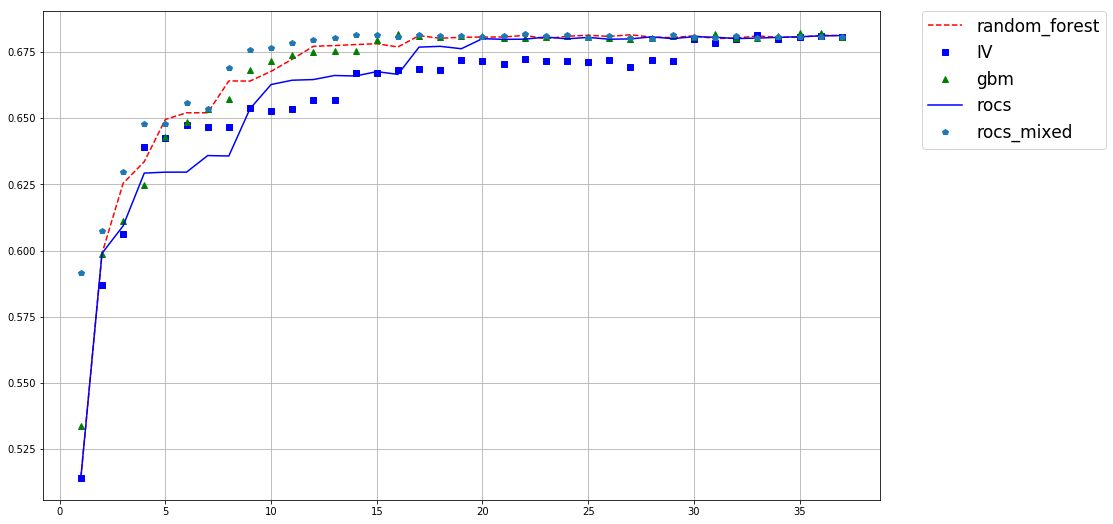

In [120]:
plt.figure(figsize=(15, 9))
random_forest_plot, = plt.plot(feat_numbers, randomforest_features_roc, 'r--', label='random_forest')
IV_plot, = plt.plot(feat_numbers, IV_features_roc, 'bs', label = 'IV')
gbm_plot, = plt.plot(feat_numbers, gbm_features_roc, 'g^', label = 'gbm')
rocs_plot = plt.plot(feat_numbers, rocs_feautures_roc, 'b', label = 'rocs')
rocs_mixed = plt.plot(feat_numbers, rocs_mixed_features_roc, 'p', label = 'rocs_mixed')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = '17')
plt.grid(True)
plt.show()

### Замечание и вывод
- Отсортированные признаки могут немного меняться в сортировке по перемешиванию столбцов
- Так как перемешивать можно по-разному
- Но из графика мы видим, что такое перемешивание дает наиболее информативный результат

# Задание NPV выполнил в отдельном ноутбуке 

** Задание (3 - 8 баллов)**

Предсказать NPV. т.е. задача регрессии и label = 'npv'.

Выбрать лучшие гиперпараметры для каждой из моделей:
    - дерево решений
    - случайный лес
    - бустинг
    
Предсказать NPV на тестовой выборке. 
<br>Поменять DecisionTreeClassifier на DecisionTreeRegressor, аналогично с RandomForest.
<br>В параметрах градиентного бустинга испольовать *'objective': 'binary'*.
<br>Метрику качества использовать **R2** sklearn.metrics.r2_score.

Файл с результатами (test_predict_m.csv) приложить к домашнему заданию.

Все предсказания с `R2 score > 0` хотя бы одной моделью (из 3) получат 3 балла.
<br>Далее ответы студентов упорядочиваются по R2 score.
1. Топ-3 получают 5 дополнительных баллов.
2. Следующие 3 получают 4 дополнительных балла.
3. Следующие 6 получают 3 дополнительных балла.
4. Следующие 10 получают 2 дополнительных балла.

## Решение

In [121]:
df_test = pd.read_csv(os.path.join(dump_path,'test_wo_labels_m.csv'))

In [122]:
df_test['decision_tree_predict'] = <your code here>
df_test['random_forest_predict'] = <your code here>
df_test['lgbm_predict'] = <your code here>

df_test['student_name'] = 'k.osminin'  # Поменяйте на свои имя фамилию

SyntaxError: invalid syntax (<ipython-input-122-09b4149d3c53>, line 1)

In [ ]:
df_test[['hl_rk','decision_tree_predict','random_forest_predict','lgbm_predict','student_name']].to_csv(
    os.path.join(dump_path,'test_predict_m.csv'),index=False)